## Validating the posterior 

The checks are used to validate the posterior of the parameter given the data that was learned. In this case we also know the ground truth, therefore, we have the possibility the validate the predicted posterior probabilities directly as well. 

For the validation we use a testing data set, $N_{test}$ number of parameters drawn from the prior, and simulated forward to give testing data $X_{test}$. 

### MSE to ground truth posterior 
To evaluate the posterior probabilities directly we just calculate the mean squared error between the predicted and the exact posterior probabilities. For every data sample in $X_{test}$ we calculate the squared error and then we take the mean over test samples. 

### Posterior quantiles
To do the quantile checks, we perform the following steps: 
    - for every test sample obtain the posterior 
    - calculate the quantile of the corresponding test parameter in the posterior distribution 

This gives $N_{test}$ quantile values. According to the paper the distribution underlying these quantile is uniform if the posterior is accurate. A first visual test is therefore to plot the histogram of quantiles and check whether it is uniform. As a next step one could perform statistical tests to test the uniformity of the empirical quantile distribution. 

### Coverage analysis: credible intervals of the quantile distribution 
Alternatively, and somehow more Bayesian, is to check the credible intervals of the quantile distribution. To this end, we count the mass in different intervals around the mode of the distribution, or, assuming that the quantile distribution is uniform in $[0, 1]$, around 0. Then we compare this mass against the width of the interval, e.g., plot the interval against the counted mass. For a perfectly uniform distribution this would be a straight line because the mass is distributed uniformly so that it exactly matches the width of the interval. In summary: 
     - count the relative number of quantiles in intervals of $0.1, \ldots, 0.5$ arond 0 of the quantile histogram
     - plot the relative counts against the width of the interval

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os 
import pickle
import sys 
import time
import tqdm

sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *
from model_comparison.models import PoissonModel, NegativeBinomialModel
%matplotlib inline

In [2]:
mpl_params = {'legend.fontsize': 15,
              'legend.frameon': False,
                      'axes.titlesize': 20,
                      'axes.labelsize': 17,
                      'xtick.labelsize': 12,
                      'ytick.labelsize': 12,
             'figure.figsize' : (18, 5)}

mpl.rcParams.update(mpl_params)

In [3]:
folder = '../data/'
fn = '201803151541_toy_example_results_N10000M10_k220.0.p'

with open(os.path.join(folder, fn), 'rb') as f: 
    d = pickle.load(f)
    
# set the seed for generating new test data 
seed = 10 
np.random.seed(seed)

In [4]:
d_model = d['model_post']
d_model.keys()

dict_keys(['seed', 'trainer', 'model_models', 'x', 'm', 'xtest', 'mtest', 'sx', 'sx_test', 'training_norm', 'param_poi', 'params_nb', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples', 'ppoi_exact'])

In [6]:
model = d_model['model_models']
x = d_model['x']
sx = d_model['sx']
xtest = d_model['xtest']
mtest = d_model['mtest']
ppoi_exact = d_model['ppoi_exact']
sx_test = d_model['sx_test']
sample_size = d_model['sample_size']

training_norm = d_model['training_norm']
k1, k2, k3 = d_model['k1'], d_model['k2'], d_model['k3']
theta1, theta2, theta3 = d_model['theta1'], d_model['theta2'], d_model['theta3']

# priors 
prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
prior_k = scipy.stats.gamma(a=k2, scale=theta2)
prior_theta = scipy.stats.gamma(a=k3, scale=theta3)

model_poisson = PoissonModel(sample_size=sample_size, seed=seed)
model_nb = NegativeBinomialModel(sample_size=sample_size, seed=seed)

# First the discrete model idx posterior

## Visualize network and test samples

### Calculate grid of predictions 

In [7]:
ms, vs = np.meshgrid(np.linspace(0, 1000, 100), np.linspace(0, 1000, 100))
# stack values to evaluate as vector in the model 
sx_vis = np.vstack((ms.flatten(), vs.flatten())).T
# normalize 
sx_vis, training_norm = normalize(sx_vis, training_norm)


# predict probs 
ppoi_vec = model.predict(sx_vis)
# take poisson posterior prob and reshape to grid dimensions
ppoi_vismat = ppoi_vec[:, 0].reshape(ms.shape[0], vs.shape[0])

### Plot exact posterior probs on top

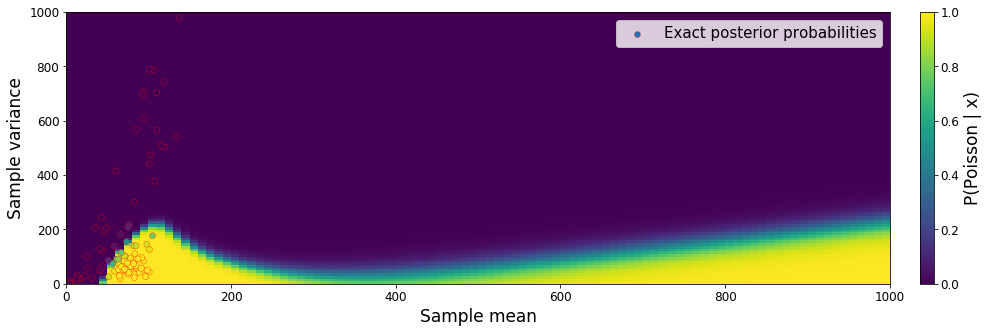

In [8]:
plt.figure(figsize=(18, 5))
cnorm = mpl.colors.Normalize(vmin=ppoi_vismat.min(), vmax=ppoi_vismat.max())
cmap = plt.cm.viridis

plt.scatter(x=sx_test[:, 0], y=sx_test[:, 1], c=np.array(ppoi_exact), cmap=cmap, norm=cnorm, edgecolors='r', linewidths=0.3)

plt.imshow(ppoi_vismat, origin='lower', aspect='auto', 
           norm=cnorm, cmap=cmap, extent=[ms.min(), ms.max(), vs.min(), vs.max()])

plt.xlabel('Sample mean')
plt.ylabel('Sample variance')
plt.colorbar(label='P(Poisson | x)', pad=0.03)
plt.legend(['Exact posterior probabilities'], frameon=True);

# MSE 

In [9]:
sx_test_zt, training_norm = normalize(sx_test, training_norm)
ppoi_hat = model.predict(sx_test_zt)[:, 0]
mse = np.mean(np.abs(ppoi_hat - ppoi_exact))
print('MAE', mse)

MAE 0.026588040121926095


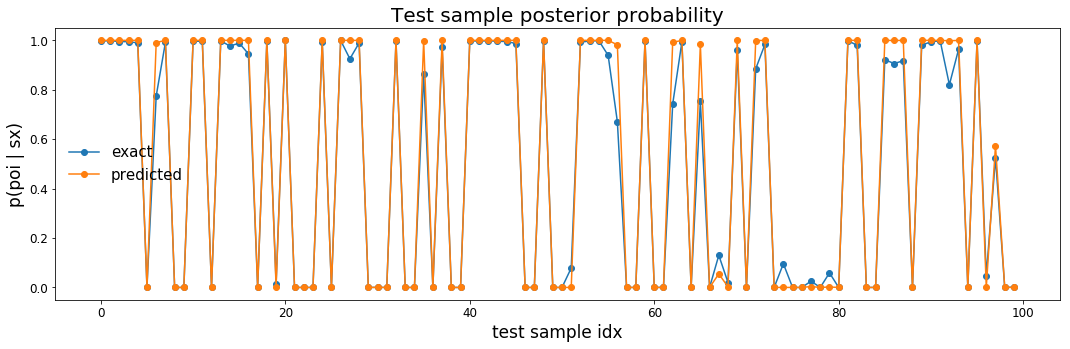

In [10]:
plt.figure(figsize=(18, 5))
plt.plot(ppoi_exact, 'o-', label='exact')
plt.plot(ppoi_hat, 'o-', label='predicted');
plt.title('Test sample posterior probability')
plt.legend()
plt.xlabel('test sample idx')
plt.ylabel('p(poi | sx)');

# Quantiles
### first generate more test data 

In [11]:
ntest = 1000

params_poi = prior_lambda.rvs(size=int(ntest / 2))
params_nb = np.vstack((prior_k.rvs(size=int(ntest / 2)), 
                       prior_theta.rvs(size=int(ntest / 2)))).T

data_poi = model_poisson.gen(params_poi)
data_nb = model_nb.gen(params_nb)

x_test = np.vstack((data_poi, data_nb))
m_test = np.hstack((np.zeros(data_poi.shape[0]), np.ones(data_nb.shape[0]))).squeeze().astype(int)
sx_test = calculate_stats_toy_examples(x_test)
# use training norm to normalize test data 
sx_test_zt, training_norm = normalize(sx_test, training_norm)

In [12]:
qis = np.ones_like(np.array(m_test)).astype(float)
# get posteriors 
posteriors = model.predict(sx_test_zt)
# get probability for m=1
p_m1s = posteriors[:, 1]

In [13]:
# calculate quantiles 
m1_mask = np.array(m_test) == 1
qis[m1_mask] = 1. - p_m1s[m1_mask]

array([470.,   3.,   2.,   1.,   2.,   1.,   1.,   1.,   1.,   3., 515.])

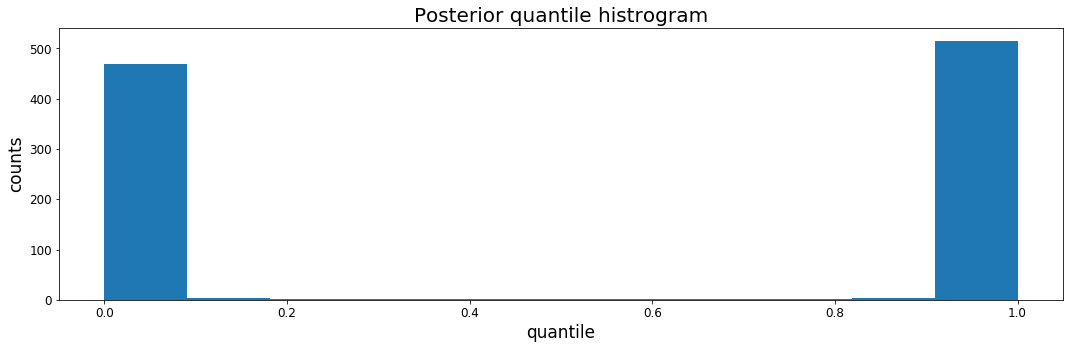

In [14]:
n, bins, patches = plt.hist(qis, bins='auto')
plt.title('Posterior quantile histrogram')
plt.xlabel('quantile')
plt.ylabel('counts')
n

# Now the continuous model parameter posterior

In [15]:
d_param_posterior = d['param_post']
d_param_posterior.keys()

dict_keys(['seed', 'trainer', 'params_mdn', 'x', 'y', 'sx', 'x_test', 'sx_test', 'y_test', 'training_norm', 'prior_norm', 'theta1', 'theta2', 'theta3', 'k1', 'k2', 'k3', 'sample_size', 'n_samples'])

In [16]:
params_posterior_mdn = d_param_posterior['params_mdn']
training_norm = d_param_posterior['training_norm']
prior_norm = d_param_posterior['prior_norm']
seed = d_param_posterior['seed']
sample_size = d_param_posterior['sample_size']

## Sample new test data 

In [62]:
ntest = 1000
prior_lambda = scipy.stats.gamma(a=k1, scale=theta1)
params_test = prior_lambda.rvs(size=ntest)
poisson_model = PoissonModel(sample_size=sample_size, seed=seed, n_workers=1)
x_test = poisson_model.gen(params_test)

In [63]:
sx_test = calculate_stats_toy_examples(x_test)
sx_test_zt, _ = normalize(sx_test, training_norm)
params_test_zt, _ = normalize(params_test, prior_norm)

## Calculate Quantiles and posterior mean differences

In [64]:
qis = np.zeros(ntest)
mus_hat = np.zeros_like(qis)
mus_exact = np.zeros_like(qis)

# for every test sample 
for ii, (thetao_i, sxo_i) in enumerate(zip(params_test_zt, sx_test_zt)): 
    
    # predict the posterior
    posterior = params_posterior_mdn.predict(sxo_i.reshape(1, -1))
    # to get the mean, first get the dd object and transform it to real parameter space 
    dd_post = posterior.get_dd_object().ztrans_inv(mean=prior_norm[0], std=prior_norm[1])
    # get the mean of the predicted posterior 
    post_mu = dd_post.mean
    mus_hat[ii] = post_mu
    
    # get the mean of the exact posterior 
    post_exact = poisson_model.get_exact_posterior(x_test[ii, :], k1, theta1)
    mus_exact[ii] = post_exact.mean()

    # get quantile of theta_o
    qis[ii] = posterior.get_quantile(thetao_i)

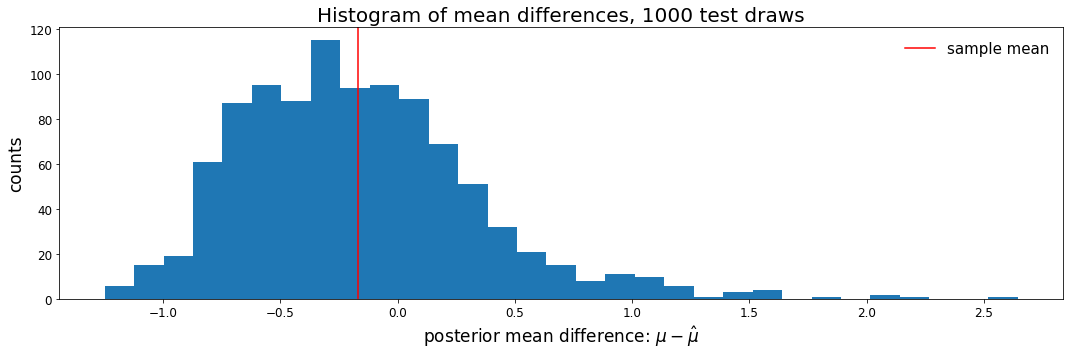

In [72]:
mean_diffs = mus_exact - mus_hat

plt.hist(mean_diffs, bins='auto')
plt.title('Histogram of mean differences, {} test draws'.format(ntest))
plt.axvline(x=mean_diffs.mean(), label='sample mean', color='r');
plt.legend()
plt.xlabel(r'posterior mean difference: $\mu - \hat{\mu}$')
plt.ylabel('counts');

In [74]:
# standard error 
sem = np.std(mean_diffs) / np.sqrt(ntest)
print('Standard error of the mean differences: {:0.2f}'.format(sem))

Standard error of the mean differences: 0.02


## Check Quantiles for Uniformity

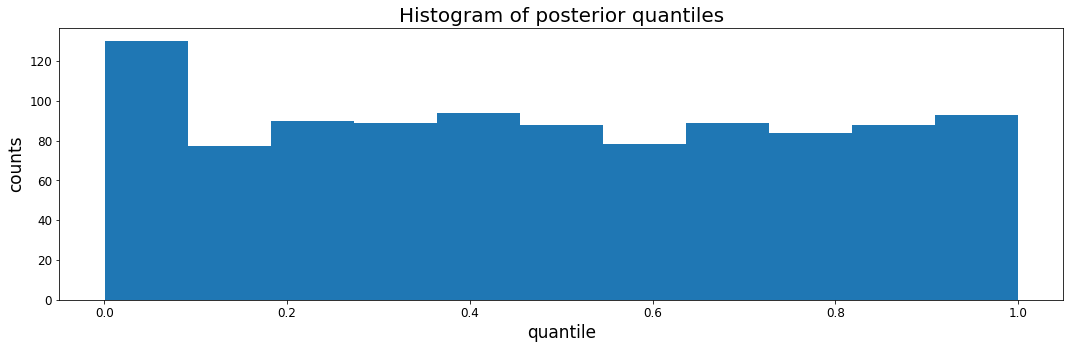

In [67]:
n, bins, patches = plt.hist(qis, bins='auto')
plt.title('Histogram of posterior quantiles')
plt.xlabel('quantile')
plt.ylabel('counts');

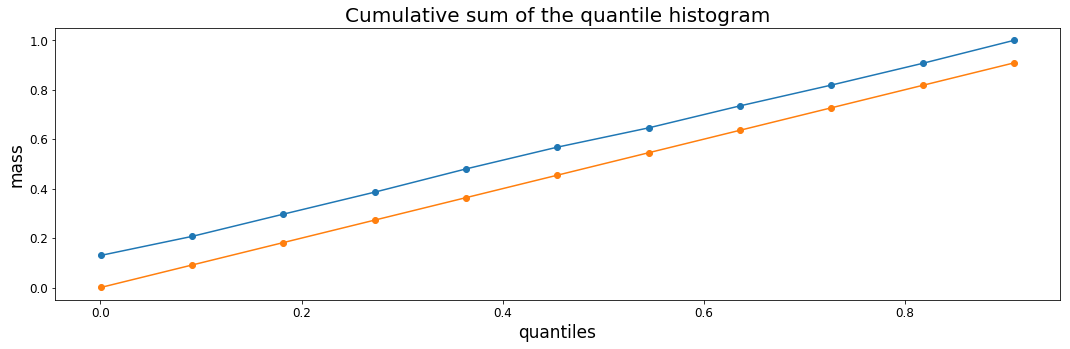

In [68]:
n /= np.sum(n)
plt.title('Cumulative sum of the quantile histogram')
plt.plot(bins[:-1], np.cumsum(n), 'o-', label='empirical quantile distribution')
plt.plot(bins[:-1], bins[:-1], 'o-', label='identity line')
plt.ylabel('mass')
plt.xlabel('quantiles');

In [69]:
scipy.stats.kstest(qis, cdf='uniform')

KstestResult(statistic=0.04100984755086573, pvalue=0.06731788846648334)